In [ ]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split


from scipy.fft import fft, fftfreq


warnings.filterwarnings(action='ignore')
torch.set_float32_matmul_precision('high')

In [2]:
data_folder = Path("D:\\F. Export data\\부족윤활")
lack231222 = data_folder/ 'RMS_231222_lacklub_1s.csv'
lack231222 = pd.read_csv(lack231222)
lack231222.head()

,Time,RMS
0,0.000000,0.260380
1,0.016672,0.256666
2,0.033343,0.245744
3,0.050015,0.243500
4,0.066687,0.232709


In [3]:
time = lack231222.Time.to_list()
signal = lack231222.RMS.to_list()

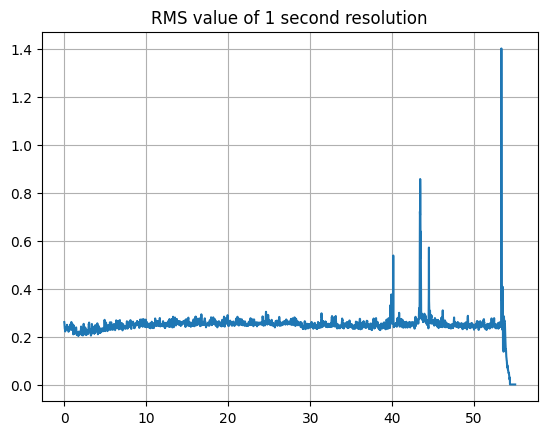

In [4]:
plt.Figure(figsize=(10,4))
plt.plot(time,signal)
plt.title("RMS value of 1 second resolution")
plt.grid(True)
plt.show()

In [38]:
# Normalize data
def normalize(input):
    mean = np.mean(input)
    input = input - mean
    std = np.std(input)
    input /= std
    return input,mean,std

signal_norm, signal_mean, signal_std = normalize(signal)
len(signal_norm)

3300

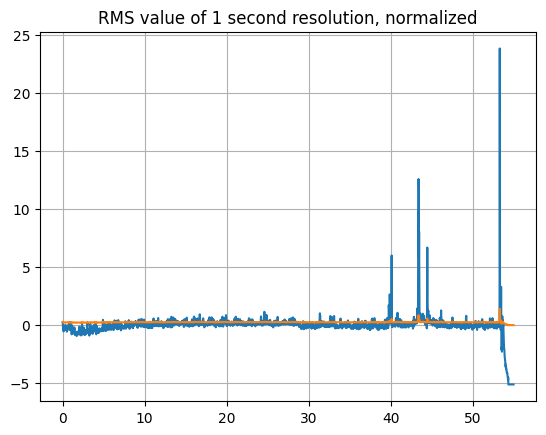

In [59]:
plt.Figure(figsize=(10,4))
plt.plot(time,signal_norm)
plt.plot(time, signal)
plt.title("RMS value of 1 second resolution, normalized")
#plt.ylim([0,1.5])
plt.grid(True)
plt.show()

In [40]:
print(f"Mean of signal {signal_mean}")
print(f"Standard deviation of signal {signal_std}")

Mean of signal 0.24788451956545451
Standard deviation of signal 0.04835297159825277


In [41]:
# Split data
training_norm = signal_norm[0:2100] # Training data is the first 30 minutes
test_norm = signal_norm[2100:] # Test data is the remain

In [42]:
# Convert 2D data to 3D data
time_step = 60

def converter(input, step = time_step):
    out = []
    for i in range (len(input)-step):
        out.append(input[i:(i+step)])
    return np.expand_dims(out,axis=2)

In [43]:
x_train = converter(training_norm)
x_test = converter(test_norm) 

In [44]:
print(x_train.shape)
print(x_test.shape)

(2040, 60, 1)
(1140, 60, 1)


In [45]:
# Split training - validation data set
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
dataset = TensorDataset(x_train_tensor,x_train_tensor)
val_size = int(0.2*len(dataset))
train_size = len(dataset)- val_size
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

batchsize = 64
train_loader = DataLoader(train_dataset, batch_size=batchsize,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize,shuffle=True)

In [46]:
n_steps = x_train.shape[1] #60 columns
n_features = x_train.shape[2] # = 1 layer
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
class ConvLSTMAutoencoder(nn.Module):
    def __init__(self, n_steps, n_features):
        super(ConvLSTMAutoencoder, self).__init__() # Inheriting from base class nn.Module, lấy những methods cần thiết chứ không bê tất
        self.n_steps = n_steps
        self.n_features = n_features

        # Conv1D encoder layer
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=128,
            kernel_size=20,
            padding='same',  # Use manual padding below
            dilation=1
        )

        # LSTM encoder
        self.lstm1 = nn.LSTM(
            input_size=128,
            hidden_size=40,
            batch_first=True
        )

        # LSTM decoder
        self.lstm2 = nn.LSTM(
            input_size=40,
            hidden_size=40,
            batch_first=True
        )

        # Conv1D decoder layer
        self.conv2 = nn.Conv1d(
            in_channels=40,
            out_channels=128,
            kernel_size=20,
            padding='same',
            dilation=1
        )

        # TimeDistributed Dense(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x): #the process of passing input data through the layers of a neural network to obtain an output
        # Input shape: (batch_size, n_steps, n_features)
        # Conv1D in PyTorch expects: (batch_size, channels=n_features, seq_len=n_steps)
        x = x.permute(0, 2, 1)  # (B = 128, C, T), batch size would be set up later, rearrange the input size
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # rearrange back to (B, T, C) for LSTM

        # LSTM encoder
        _, (h_n, _) = self.lstm1(x)
        h = h_n[0]  # (B, hidden)

        # RepeatVector
        h_repeated = h.unsqueeze(1).repeat(1, self.n_steps, 1)  # (B, T, hidden)

        # LSTM decoder
        x_decoded, _ = self.lstm2(h_repeated)

        # Conv1D decoder
        x_decoded = x_decoded.permute(0, 2, 1)  # (B =128, C=25, T)
        x_decoded = self.conv2(x_decoded)

        # Final TimeDistributed Dense layer
        x_decoded = x_decoded.permute(0, 2, 1)  # (B, T, C=32)
        output = self.fc(x_decoded)  # (B, T, 1)

        return output
model = ConvLSTMAutoencoder(n_steps=n_steps, n_features=n_features)
model.to(device)  # Move model to GPU or CPU

# Optimizer and Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,weight_decay=1e-5)
criterion = nn.MSELoss()

# Print summary-like info
print(model)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")


ConvLSTMAutoencoder(
  (conv1): Conv1d(1, 128, kernel_size=(20,), stride=(1,), padding=same)
  (lstm1): LSTM(128, 40, batch_first=True)
  (lstm2): LSTM(40, 40, batch_first=True)
  (conv2): Conv1d(40, 128, kernel_size=(20,), stride=(1,), padding=same)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Current Device: 0


In [47]:
# Initialize training setup
epochs = 200
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    


    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")
    print(batch_x.device)

Epoch 1/200 - Train Loss: 0.0932 - Val Loss: 0.0912
Epoch 2/200 - Train Loss: 0.0921 - Val Loss: 0.0901
Epoch 3/200 - Train Loss: 0.0911 - Val Loss: 0.0891
Epoch 4/200 - Train Loss: 0.0903 - Val Loss: 0.0884
Epoch 5/200 - Train Loss: 0.0896 - Val Loss: 0.0877
Epoch 6/200 - Train Loss: 0.0890 - Val Loss: 0.0871
Epoch 7/200 - Train Loss: 0.0885 - Val Loss: 0.0866
Epoch 8/200 - Train Loss: 0.0880 - Val Loss: 0.0861
Epoch 9/200 - Train Loss: 0.0876 - Val Loss: 0.0857
Epoch 10/200 - Train Loss: 0.0872 - Val Loss: 0.0853
Epoch 11/200 - Train Loss: 0.0869 - Val Loss: 0.0850
Epoch 12/200 - Train Loss: 0.0866 - Val Loss: 0.0847
Epoch 13/200 - Train Loss: 0.0863 - Val Loss: 0.0844
Epoch 14/200 - Train Loss: 0.0860 - Val Loss: 0.0841
Epoch 15/200 - Train Loss: 0.0858 - Val Loss: 0.0838
Epoch 16/200 - Train Loss: 0.0855 - Val Loss: 0.0835
Epoch 17/200 - Train Loss: 0.0853 - Val Loss: 0.0833
Epoch 18/200 - Train Loss: 0.0850 - Val Loss: 0.0830
Epoch 19/200 - Train Loss: 0.0848 - Val Loss: 0.0828
Ep

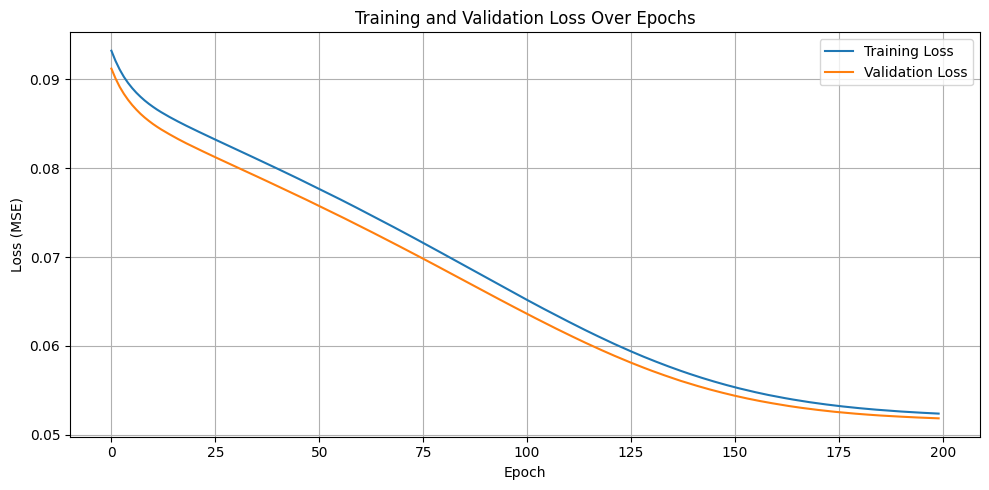

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

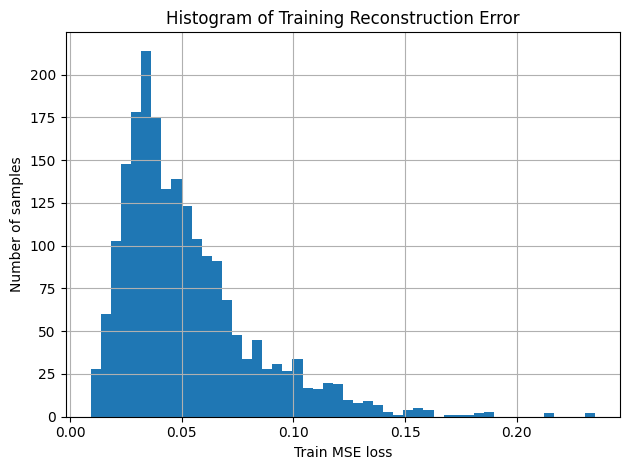

Reconstruction error threshold: 0.23495635


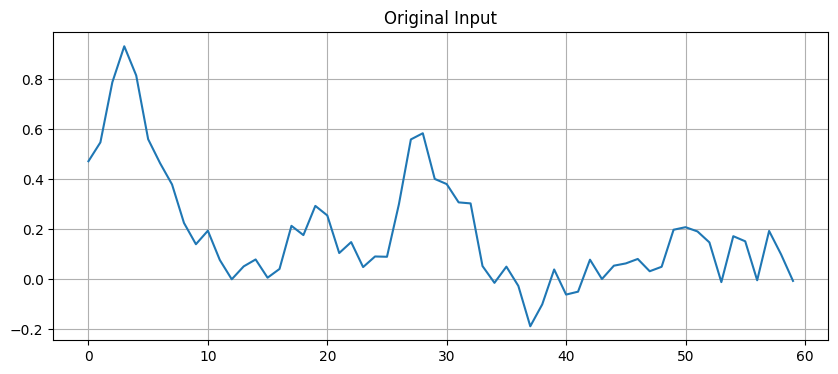

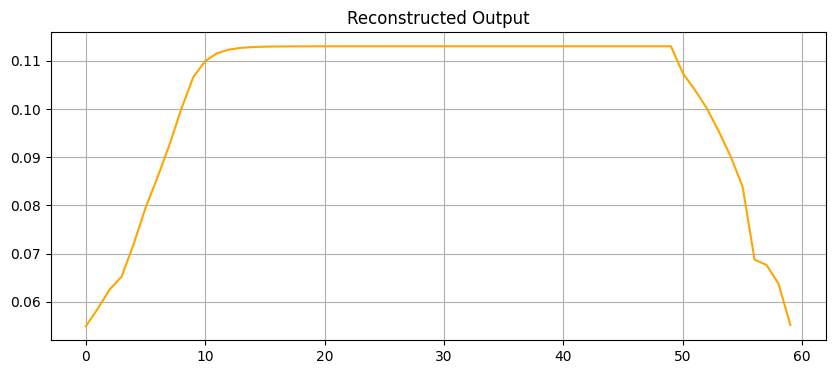

In [49]:
# Make sure model is in eval mode and data is on correct device
model.eval()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

# 1. Predict training data
with torch.no_grad():
    x_train_pred = model(x_train_tensor)

# 2. Move tensors to CPU and convert to NumPy
x_train_pred_np = x_train_pred.cpu().numpy()
x_train_np = x_train_tensor.cpu().numpy()

# 3. Compute MSE per sample (mean over all time steps and features)
# Assume shape is (batch_size, time_steps, features)
train_mse_loss = np.mean(np.square(x_train_pred_np - x_train_np), axis=(1, 2))  # axis=1 for time only, or (1,2) for full sequence

# 4. Plot histogram of reconstruction loss
plt.hist(train_mse_loss, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Training Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Set anomaly threshold
threshold = np.max(train_mse_loss)
print("Reconstruction error threshold:", threshold)

# 6. Plot first input vs reconstruction
plt.figure(figsize=(10, 4))
plt.plot(x_train_np[1000], label="Original")
plt.title("Original Input")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_train_pred_np[1000], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
plt.show()

In [50]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    x_test_pred_tensor = model(x_test_tensor)

x_test_pred = x_test_pred_tensor.cpu().numpy()
x_test_np = x_test_tensor.cpu().numpy()

Reconstruction error threshold: 16.59203


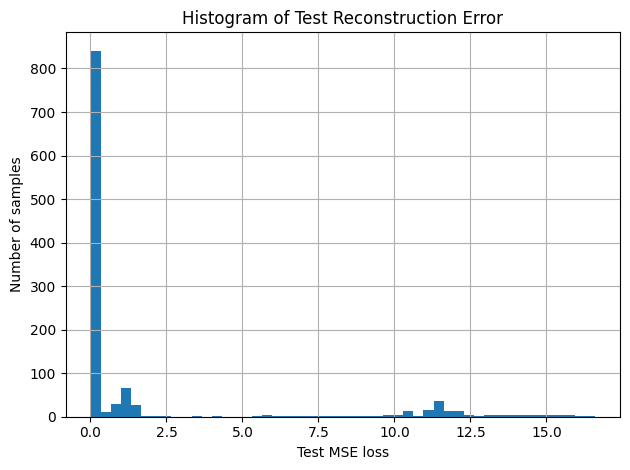

Number of anomaly samples: 305
Indices of anomaly samples: [ 233  234  235  236  237  238  239  240  241  242  243  244  245  246
  247  248  249  250  251  252  253  254  255  256  257  258  259  260
  261  262  263  264  265  266  267  268  269  270  271  272  273  274
  275  276  277  278  279  280  281  282  283  284  285  286  287  288
  289  290  291  292  293  294  295  296  297  298  299  300  301  302
  303  304  305  306  307  442  443  444  445  446  447  448  449  450
  451  452  453  454  455  456  457  458  459  460  461  462  463  464
  465  466  467  468  469  470  471  472  473  474  475  476  477  478
  479  480  481  482  483  484  485  486  487  488  489  490  491  492
  493  494  495  496  497  498  499  500  501  502  503  504  505  506
  507  508  509  510  511  512  513  514  515  516  517  518  519  520
  521  522  523  524  525  526  527  528  529  530  531  532  533  534
  535  536  537  538  539  540  541  542  543  544  545  546  547  548
  549  550  551  5

In [51]:
test_mse_loss = np.mean(np.square(x_test_pred - x_test_np), axis=(1, 2))  # Shape: (num_samples,)
threshold_test = np.max(test_mse_loss)
print("Reconstruction error threshold:", threshold_test)
plt.hist(test_mse_loss, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Test Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# threshold must be defined earlier (e.g., from training data)
anomalies = test_mse_loss > threshold

print("Number of anomaly samples:", np.sum(anomalies))
print("Indices of anomaly samples:", np.where(anomalies)[0])

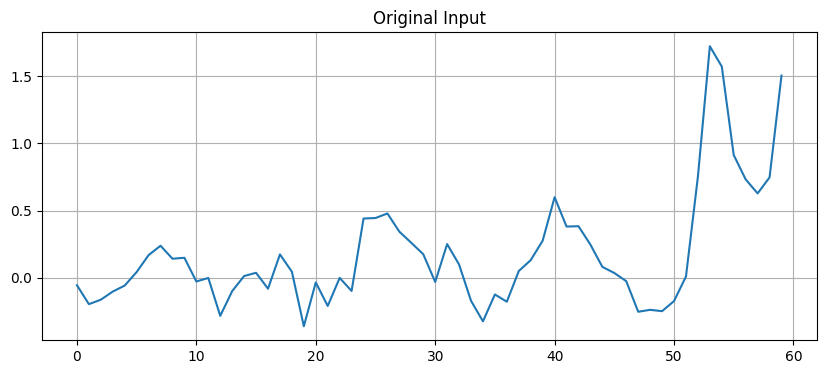

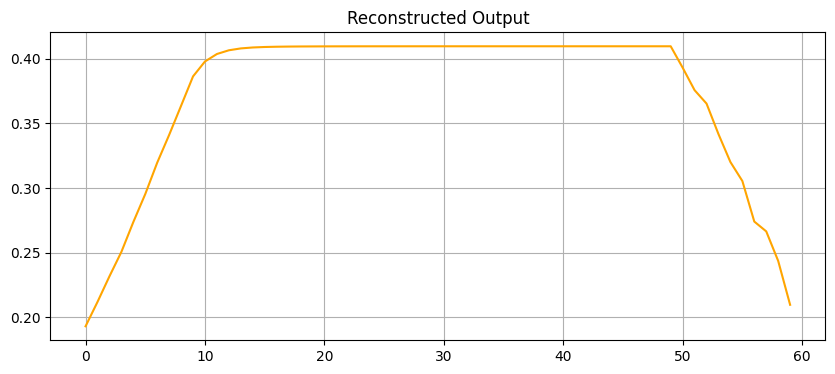

In [52]:
# Plot first input vs reconstruction of test data
plt.figure(figsize=(10, 4))
plt.plot(x_test_np[233], label="Original")
plt.title("Original Input")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_test_pred[233], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
plt.show()

In [53]:
# Extracting the indices of anomalous
anomalous_data_indices = []

for data_idx in range(time_step - 1, len(test_norm) - time_step + 1):
    time_series = range(data_idx - time_step + 1, data_idx)
    if all(anomalies[j] for j in time_series):
        anomalous_data_indices.append(data_idx)

In [54]:
anomalous_data = test_norm[anomalous_data_indices]
time_test = time[2100:]
anomalies_time = []
for i in anomalous_data_indices:
    anomalies_time.append(time_test[i])

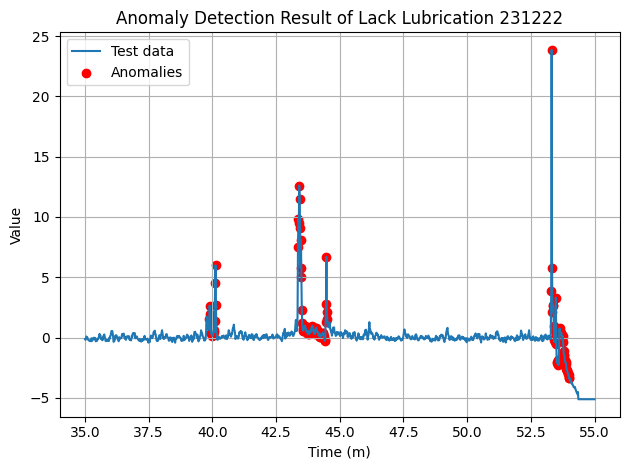

In [55]:
plt.Figure(figsize=(10,4))
plt.plot(time_test,test_norm,label= "Test data")
plt.scatter(anomalies_time,anomalous_data,color = 'red',label="Anomalies" )
plt.legend()
plt.title("Anomaly Detection Result of Lack Lubrication 231222")
plt.xlabel("Time (m)")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()